In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#################################################
############ DEFINIZIONE DI FUNZIONI ############
#################################################

In [3]:
def numerov(k2, h, ya, yb, direction='forward'):
    """
    Algoritmo di numerov
    """ 
    M=len(k2)
    y=np.zeros(M)
    
    # FORWARD NUMEROV ALGORYTM
    if direction=='forward':
        #initial conditions
        y[0]=ya
        y[1]=yb
        #algorytm
        for i in range(1,M-1):
                y[i+1] = (y[i] * (2- 5*h**2/6 * k2[i]) - y[i-1] * (1 + h**2/12 * k2[i-1]) ) / (1 + h**2/12 * k2[i+1])

                
    # BACKWORD NUMEROV ALGORYTM
    if direction=='backward':
        y=np.zeros(M)
        #initial conditions
        y[M-1]=ya
        y[M-2]=yb
        #algorytm
        for i in range(M-2,0,-1):
                y[i-1] = (y[i] * (2- 5*h**2/6 * k2[i]) - y[i+1] * (1 + h**2/12 * k2[i+1]) ) / (1 + h**2/12 * k2[i-1])

    return y

In [4]:
def root_finder(f, begin, end_or_n_roots, step, tol, method='n_roots' ):
    """
    Find roots of a function

    'n_roots' or 'end'
    """

    if method == 'end':
        # coarse find of roots
        E=np.arange(begin,end_or_n_roots,step)
        yM=f(E)
        
        root_bound=[]
        for i in range(1,len(E)):
            if np.sign(yM[i]) != np.sign(yM[i-1]):
                root_bound.append([i-1,i])

    
        # finer find of roots
        roots=[]
        for k in root_bound:
            E_p=E[k[1]]
            E_m=E[k[0]]
            n_iter=0
            #while (abs((E_p-E_m)/(E_p+E_m)*2)>tol)&(n_iter<100):
            while (abs((E_p-E_m)/2)>tol)&(n_iter<100):
                E_temp=(E_p+E_m)/2
                if np.sign(f(E_m)) != np.sign(f(E_temp)):
                    E_p = E_temp
                if np.sign(f(E_temp)) != np.sign(f(E_p)):
                    E_m = E_temp
                n_iter=n_iter+1
            roots.append([(E_p+E_m)/2, E_p-E_m])

    if method =='n_roots':
        # coarse find of roots

        E1=begin
        E2=begin+step
        y1=f(E1)

        root_bound=[]
        while len(root_bound)<end_or_n_roots:
            y2=f(E2)
            if np.sign(y2) != np.sign(y1):
                root_bound.append([E1,E2])
            y1=y2
            E1=E1+step
            E2=E2+step

    
        # finer find of roots
        roots=[]
        for k in root_bound:
            E_p=k[0]
            E_m=k[1]
            n_iter=0
            while (abs(E_p-E_m)>tol)&(n_iter<100):
                E_temp=(E_p+E_m)/2
                if np.sign(f(E_m)) != np.sign(f(E_temp)):
                    E_p = E_temp
                if np.sign(f(E_temp)) != np.sign(f(E_p)):
                    E_m = E_temp
                n_iter=n_iter+1
            roots.append([(E_p+E_m)/2, E_p-E_m])

    return roots

In [5]:
def eigenvalue_finder(f, begin, stop, step, tol, stop_method='n_roots' ):
    """
    Find the eigenvalues of the Numerov problem looking for the zeros of the last point y_M
    'n_roots' or 'range'
    """
    
    # coarse find of roots

    E1=begin
    E2=begin+step
    y1=f(E1)
    M=len(y1)-1
    y1_M=y1[M]
    del y1
    

    root_bound=[]
    while len(root_bound)<stop if stop_method=='n_roots' else E2 <= stop:
        y2_M=f(E2)[M]
        if np.sign(y2_M) != np.sign(y1_M):
            root_bound.append([E1,E2])
        y1_M=y2_M
        E1=E1+step
        E2=E2+step
    
    # finer find of roots
    roots=[]
    for k in root_bound:
        #initial values of the loop
        E1=k[0]
        E2=k[1]

        y1=f(E1)
        y1_M=y1[M]
        y2=f(E2)
        y2_M=y2[M]
        y1_max=np.max(y1)
        y2_max=np.max(y2)
        del y1,y2

        max_iter=100
        iter=0
        while (abs(y2_M-y1_M) > tol*np.max([y1_max,y2_max]))&(iter<=max_iter):

            E_temp=(E2+E1)/2

            ytemp = f(E_temp)
            ytemp_M = ytemp[M-1]
            ytemp_max=np.max(ytemp)

            if np.sign(y1_M) != np.sign(ytemp_M):
                E2 = E_temp
                y2_M = ytemp_M
                y2_max=ytemp_max
            if np.sign(ytemp_M) != np.sign(y2_M):
                E1 = E_temp
                y1_M=ytemp_M
                y1_max=ytemp_max
            iter=iter+1

        if iter==max_iter:
            print('WARNING: reached maximum number of iterations in the bissection algorithm')
        roots.append([(E2+E1)/2, E2-E1])

    return roots

## 1-st point

In [6]:
# MASH
h=0.1
x=np.arange(-3.75,3.75,h)
x=np.arange(-7,7,h)
M=len(x)

# POTENTIAL
V = lambda x : x**2/2

#k^2
k2 = lambda E : 2 * (E - V(x))


In [7]:
#CERCHIAMO GLI AUTOVALORI

y = lambda E : numerov(k2(E),h,0,h)

n_max=5
eigen = eigenvalue_finder(y, 0, n_max, 0.01, 0.001,stop_method='n_roots')

# creo tabella (dataframe) degli autovalori
eigenvalues = pd.DataFrame(0, index=np.arange(n_max), columns=['E','dE'])
eigenvalues.loc[:]=np.array(eigen)
eigenvalues.insert(0,'n',np.arange(n_max))
display(eigenvalues)

,n,E,dE
0,0,0.500000,2.910450e-13
1,1,1.499997,2.328138e-12
2,2,2.499990,9.312995e-12
3,3,3.499975,7.450573e-11
4,4,4.499949,2.980229e-10


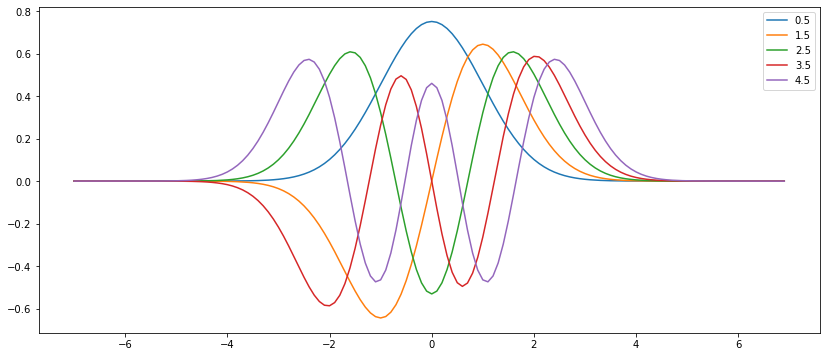

In [8]:
err=np.arange(0,M)*h**6
plt.figure(figsize=(14,6))

for En in enumerate(eigenvalues.E):
    
    y = (-1)**(En[0]) * numerov(k2(En[1]),h,0,h)
    y = y/np.sqrt(np.sum(y**2*h))

    #plot con bande di errori
    plt.plot(x,y,label=str(round(En[1],3)))
    plt.fill_between(x,y-err,y+err,alpha=0.3)

plt.legend()

## 2-nd point

In [79]:
# MASH
h=0.1
r=np.arange(0,8,h)
M=len(r)

# POTENTIAL
V = lambda r : r**2/2

#k**2
def k2_temp(E,l,V,r):
    out=(2 * (E - V(r[1:])) - (l+1)*l/r[1:]**2)
    return np.append([0],out)

k2 = lambda E , l : k2_temp(E, l, V, r)


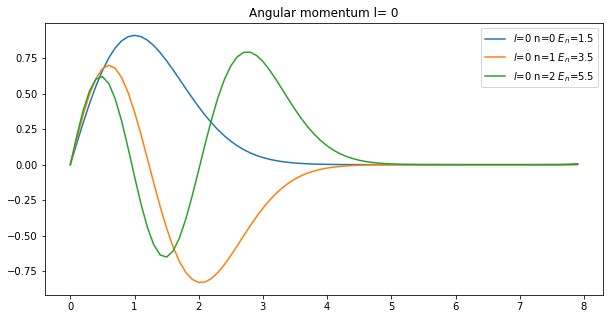

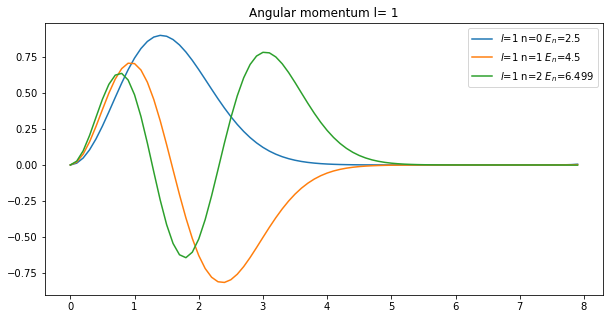

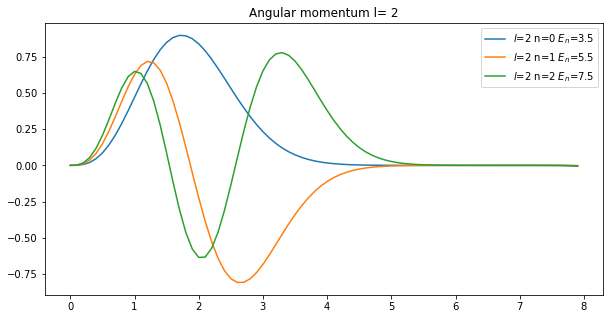

,l,n,E,dE
0,0,0,1.499997,4.551914e-14
1,0,1,3.499975,1.455280e-12
2,0,2,5.499909,4.656542e-11
3,1,0,2.499885,1.820766e-13
4,1,1,4.499693,5.820233e-12
5,1,2,6.499413,1.862652e-10
6,2,0,3.499995,1.455280e-12
7,2,1,5.499971,2.328271e-11
8,2,2,7.499904,3.725287e-10


In [80]:
l_max=3
n_max=3
eigenvalues = pd.DataFrame(0, index=np.arange(l_max*n_max), columns=['E','dE'])
n_quantum=[]
l_quantum=[]
for l in range(l_max):
    # calcolo autovalori
    y = np.vectorize(lambda E : (numerov(k2(E,l),h,0,h**(l+1))))
    eigen = eigenvalue_finder(y, 0, n_max, 0.1, 0.01,stop_method='n_roots')
    
    #creo tabella autovalori
    eigenvalues.loc[n_max*l:n_max+n_max*l-1]=np.array(eigen)
    
    plt.figure(figsize=(10,5))
    for En in enumerate(np.array(eigen)[:,0]):
        y = numerov(k2(En[1],l),h,0,h)
        y = y/np.sqrt(np.sum(y**2*h))

        n_quantum.append(En[0])
        l_quantum.append(l)

        #plot con bande di errori
        plt.plot(r,y,label=f'$l$=%s'%l+' n=%s'%En[0]+f' $E_n$='+str(round(En[1],3)))
        err=np.arange(0,M)*h**6
        plt.fill_between(r,y-err,y+err,alpha=0.3)

    plt.title('Angular momentum l= %s'%l)
    plt.legend()
    plt.show()

eigenvalues.insert(0,'l',l_quantum)  
eigenvalues.insert(1,'n',n_quantum)    
display(eigenvalues)


# 3-rd point

Dovremmo fare una cosa di questo tipo che funziona, ma appena la butto in un for non va più...
Non funziona se invece che passargli il numero lo passo attraverso l del for!
Non ho idea del perchè

In [61]:
N=5
N=N+1
j=list(range(N))

j[0]=lambda x : np.sin(x)/x

l=1
j[1]=lambda x : (2*l+1)/x * j[0](x) - np.cos(x)/x
l=2
j[2]=lambda x : (2*l+1)/x * j[1](x) - j[0](x)
l=3
j[3]=lambda x : (2*l+1)/x * j[2](x) - j[1](x)
l=4
j[4]=lambda x : (2*l+1)/x * j[3](x) - j[2](x)
l=5
j[5]=lambda x : (2*l+1)/x * j[4](x) - j[3](x)


In [62]:
j[5](3)

69.0863073238291

ma appena metto qualcosa in un ciclo non funziona più.....

In [59]:
N=5
N=N+1
j=list(range(N))

j[0]=lambda x : np.sin(x)/x

for l in range(1,2):
    j[l] = lambda x : (2*l+1)/x * j[l-1](x) - np.cos(x)/x
#j[1]=lambda x : (2*l+1)/x * j[0](x) - np.cos(x)/x
l=2
j[2]=lambda x : (2*l+1)/x * j[1](x) - j[0](x)
l=3
j[3]=lambda x : (2*l+1)/x * j[2](x) - j[1](x)
l=4
j[4]=lambda x : (2*l+1)/x * j[3](x) - j[2](x)
l=5
j[5]=lambda x : (2*l+1)/x * j[4](x) - j[3](x)


In [20]:
N=5
N=N+1
j=list(range(N))

j[0]=lambda x : np.sin(x)/x
for l in range(1,N):
    if l == 1:
        j[l] = lambda x : (2*l+1)/x * j[l-1](x) - np.cos(x)/x
    else:
        j[l] = lambda x : (2*l+1)/x * j[l-1](x) - j[l-2](x)
